# Multi-layer Perceptron

[Andrej Karpathy LLM Tutorial pt 2](https://www.youtube.com/watch?v=TCH_1BHY58I)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 09/10/2025   | Martin | Create  | Completed initial model | 
| 15/10/2025   | Martin | New  | Train/ Val/ Test split | 
| 21/10/2025   | Martin | Update  | Finished with model improvements | 

# Content

* [Introduction](#introduction)
* [Setup](#setup)
* [Model](#model)

In [1]:
%load_ext watermark

# Introduction

The original bag-of-words model and count frequency model fails because as the context length (in this case the number of characters used to predict the next character) increases, the matrix becomes intractable for computation.

Learning is also limited due to the number of tunable parameters in the system, making relationships harder to model.

The solution is as follows:
- Project inputs (characters, words, etc.) to a representative lower dimensional space
- Increase the number of paramters to capture more complex relationships

# Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("data/names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# Building the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {v: k+1 for k, v in enumerate(chars)}
stoi['.'] = 0
itos = {v: k for k, v in stoi.items()}

In [4]:
# Build the dataset
block_size = 3 # context length
X, Y = [], []
# for w in words[:5]: # For smaller dataset
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(f"{''.join([itos[i] for i in context])} ---> {itos[ix]}")
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

# Model

Convert the 27 letters into a 2 dimensional representation. Then pass it through 2 layers, with the output layer being a 27 dimension vector representing the letters

In [6]:
C = torch.randn((27, 2)) # second number is the embedding dimensions space
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [7]:
# Assuming the first layer has 100 neurons
W1 = torch.randn((6, 100)) # 6 because if the embedding space is 2 and the block_size is 3, for each entry there are 6 inputs
b1 = torch.randn(100)
W1.shape

torch.Size([6, 100])

The embedding input space is incompatible with the number of neurons. So, we reshape the tensor using `.view()` to make it fit

In [8]:
m = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(m)

In [9]:
# Second layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [10]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

This is the current probability distribution based on the training data. To get the loss, we index the target letters from this distribution and compute the negative log-likelihood.

In [27]:
prob.shape

torch.Size([32, 27])

In [28]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.9013)

In [29]:
# Use the cross entropy function in torch to simplify the above cells to get loss
loss = F.cross_entropy(logits, Y)
loss

tensor(16.9013)

Putting it together

In [50]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 3481


In [51]:
# Setting a custom learning rate picker
# Iterates through a list of decreasing learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
lri = []
lossi = []

for i in range(1000):

  # Minibatch construct
  ix = torch.randint(0, X.shape[0], (32, ))

  # Forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])

  # Backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = lrs[i]
  # lr = 0.1 # based on the graph, the lowest point observed is ~0.1
  for p in parameters:
    p.data += -lr * p.grad
  
  # Append stats
  lri.append(lre[i])
  lossi.append(loss.item())

print(loss.item())

8.22642993927002


Text(0.5, 1.0, 'Learning Rate Exponent vs. Loss')

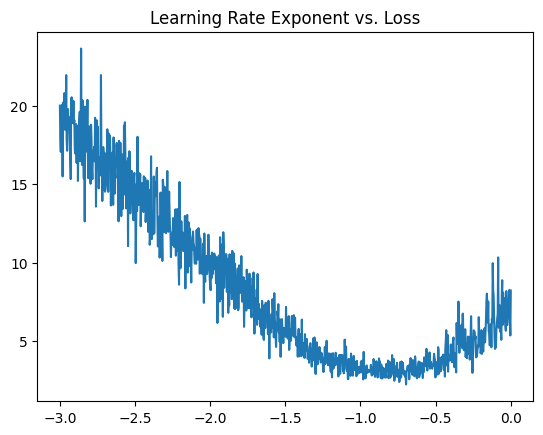

In [53]:
plt.plot(lri, lossi)
plt.title("Learning Rate Exponent vs. Loss")

We observe that the smallest loss value occurs when the exponentiated learning rate is approximately -1, therefore a good learning rate would be -0.1. This is found by selecting the lowest point of the loss curve

## Train/ Val/ Test split

In [11]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g) # represents the weights of each letter
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 3481


In [17]:
for i in range(10000):

  # Minibatch construct
  ix = torch.randint(0, X_train.shape[0], (32, ))

  # Forward pass
  emb = C[X_train[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_train[ix])

  # Backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 # based on the graph, the lowest point observed is ~0.1
  for p in parameters:
    p.data += -lr * p.grad

print(loss.item())

2.5224339962005615


In [18]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
loss.item()

2.4136736392974854

We observe here that the training and validation loss are __very close__. This indicates that the model is __underfitting__, we would expect the training loss to be lower than the validation loss, since the model has access to the training examples.

Therefore, here are some possible improvements:

1. __Increase the size of the network__ - This increases the number of weights the model can optimise for, making it able to recognise more relationships
2. __Increase the batch size__ - Batch size can limit how the model transitions across each step. A larger step allows the model to recognise more meaningful patterns at each iteration reducing _noise_
3. __Increase embedding dimensions__ - Each word/ letter has more "meaning" encoded in them for the model to recognise

In [43]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # 3. increase embedding dimensions
W1 = torch.randn((30, 200), generator=g) # 1. increase size of the network
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 11897


In [44]:
steps = []
lossi = []

In [45]:
for i in range(200_000):

  # Minibatch construct
  ix = torch.randint(0, X_train.shape[0], (64, )) # 2. increase the batch size

  # Forward pass
  emb = C[X_train[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_train[ix])

  # Backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Store Statistics
  steps.append(i)
  lossi.append(loss.log10().item())

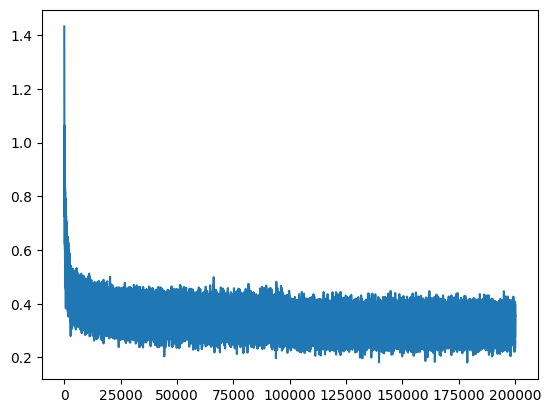

In [46]:
plt.plot(steps, lossi)

In [47]:
# Evaluate training loss
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(f"Training Loss is {loss}")

Training Loss is 2.1216020584106445


In [48]:
# Evaluate validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
print(f"Validation Loss is {loss}")

Validation Loss is 2.1647984981536865


<u>Observations</u>

- Vowels are clustered together near the bottom. Model sees them as similar and potentially interchangeable (as expected)
- "q" and "g" are further away indicating that Model is learning some unique chracteristics about those specific letters

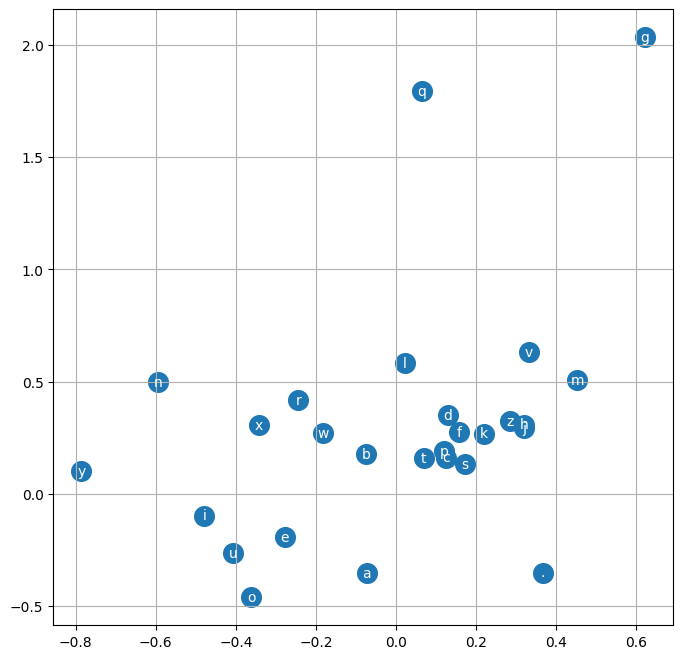

In [27]:
# Visualise the embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

Sampling from the Model

In [58]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
myli.
taty.
skaelane.
rahnen.
delynn.
jareei.
nellara.
chaiiv.
kaleigh.
ham.
join.
quint.
shoveri.
jadis.
wazell.
dearyxi.
jace.


In [57]:
%watermark

Last updated: 2025-10-15T22:43:28.413803+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

